# Introduction

**Replication of Shao et al. (2023) Figure 4 using the DCS Package**

This notebook demonstrates the use of the `dcs` Python package to replicate key findings related to dynamic causal analysis, specifically targeting results similar to Figure 4 from the paper "Information theoretic measures of causal influences during transient neural events" by [Shao, Logothetis, & Besserve (2023)](https://www.frontiersin.org/journals/network-physiology/articles/10.3389/fnetp.2023.1085347/full).

We will perform the following steps:
1.  Import necessary libraries and functions from the `dcs` package.
2.  Define parameters for simulating coupled oscillator time series data, matching the setup used in the original paper where possible.
3.  Run multiple simulations to generate trial data.
4.  Calculate time-varying causality measures (Transfer Entropy, Dynamic Causal Strength, Granger Causality) for each simulation run using `dcs`.
5.  Average the results across runs and prepare data for plotting.
6.  Generate plots visualizing example time series, noise profiles, and the calculated causality measures over time, similar to the original Figure 4.

## Imports

First, we import the necessary libraries: `numpy` for numerical operations, `matplotlib` for plotting, and specific functions from our `dcs` package for simulation (`generate_signals`), causality calculation (`DCSCalculator`), and plotting helpers (`fill_std_known`).

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from dcs import DCSCalculator, generate_signals
from dcs.utils import fill_std_known
from matplotlib.gridspec import GridSpec

## Simulation Parameters

This cell defines all the parameters needed for the simulation and subsequent plotting. It includes settings for the coupled oscillators (periods, damping ratios, frequencies - intended to match Shao et al.), simulation length (T) and number of trials (Ntrial), time step (h), plotting colors, and y-axis limits.

In [2]:
# Plotting settings
colors = [ # Standard color cycle (e.g., MATLAB default)
            [0, 0.4470, 0.7410], # Blue
            [0.8500, 0.3250, 0.0980], # Orange
            [0.9290, 0.6940, 0.1250], # Yellow
            [0.4940, 0.1840, 0.5560], # Purple
            [0.5, 0.5, 0.5]           # Grey
            ]
y_up = 0.025 # Upper y-limit for plots
y_lo = 0     # Lower y-limit for plots

# Coupled oscillator parameters (matching Shao et al. (2023) Fig 4 setup)
T1 = 200         # Period for oscillator 1 (time units)
T2 = 20          # Period for oscillator 2 (time units)
zeta1 = 0.015722 # Damping ratio for oscillator 1
zeta2 = 0.2      # Damping ratio for oscillator 2

Omega1 = 2 * np.pi / T1 # Angular frequency 1
Omega2 = 2 * np.pi / T2 # Angular frequency 2
gamma1 = 2 * zeta1 * Omega1 # Damping factor 1
gamma2 = 2 * zeta2 * Omega2 # Damping factor 2

h = 1 # Time step for simulation (used in generate_signals)

# Simulation run parameters
T = 1000      # Total time points per trial for simulation run
Ntrial = 2000 # Number of trials to simulate

## Run Simulations and Compute Causality

This cell performs the core computation. It runs a loop (`num_sim_runs` times) where each iteration:

1. Generates a new dataset `X` with `Ntrial` trials using `generate_signals` and the parameters defined above.
2. Computes the time-varying Transfer Entropy (TE), Dynamic Causal Strength (DCS), and Granger Causality (GC) between the two signals in `X` using `DCSCalculator`. 
   1. We use a fixed model order here; alternatively, model order selection could be performed within the loop.
3. Stores the results (`cs`, `te`, `gc` arrays) from each run in lists.

Using multiple runs helps assess the variability and stability of the causality estimates.

### Control Case Simulation and Analysis

The following cells simulate data under standard stationary noise conditions (using `generate_signals` with `apply_morlet=False`) and analyze the resulting causal interactions using the `dcs` package.

In [3]:
# Initialize lists to store results
causal_strength_results = []
transfer_entropy_results = []
granger_causality_results = []

# Configuration
num_sim_runs = 20
fixed_model_order = 2
use_diag_cov = False

print(f"Starting {num_sim_runs} simulation runs with model order {fixed_model_order}...")
start_time = time.time()

dcs_calculator = DCSCalculator(
    model_order=fixed_model_order,
    time_mode='inhomo',
    use_diagonal_covariance=use_diag_cov
)

for i in range(num_sim_runs):
    print(f"Running simulation {i+1}/{num_sim_runs}...")
    X, ns_x, ns_y = generate_signals(T, Ntrial, h, gamma1, gamma2, Omega1, Omega2)

    try:
        result = dcs_calculator.analyze(X)
        
        cs = result.causal_strength
        te = result.transfer_entropy
        gc = result.granger_causality

        causal_strength_results.append(cs)
        transfer_entropy_results.append(te)
        granger_causality_results.append(gc)
    except Exception as e:
        print(f"Error during causality calculation in run {i+1}: {e}")
        expected_time_points = T - fixed_model_order # Calculate expected time points in output
        if expected_time_points > 0:
             causal_strength_results.append(np.full((expected_time_points, 2), np.nan))
             transfer_entropy_results.append(np.full((expected_time_points, 2), np.nan))
             granger_causality_results.append(np.full((expected_time_points, 2), np.nan))

end_time = time.time()
print(f"\nFinished {num_sim_runs} runs in {end_time - start_time:.2f} seconds.")

try:
    causal_strength_results = np.array(causal_strength_results)
    transfer_entropy_results = np.array(transfer_entropy_results)
    granger_causality_results = np.array(granger_causality_results)

    print(f"\nResult array shapes (runs, time, directions):")
    print(f"  CS:  {causal_strength_results.shape}")
    print(f"  TE:  {transfer_entropy_results.shape}")
    print(f"  GC:  {granger_causality_results.shape}")

except ValueError as e:
    print(f"\nError converting results to NumPy arrays. Likely due to inconsistent shapes from run errors: {e}")
    print("Inspect the lists directly.")

Starting 20 simulation runs with model order 2...
Running simulation 1/20...
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 2/20...
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 3/20...
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 4/20...
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 5/20...
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 6/20...
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 7/20...
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 8/20...
Starting DCSCalculator analysis on data w

#### Calculate Statistics and Average Results

This cell processes the results collected from the multiple simulation runs. It calculates the mean and standard deviation across the runs for each causality measure (TE, CS, GC) using `np.nanmean` and `np.nanstd` for robustness against any potential errors that might have resulted in `NaN` values during calculation. Finally, it defines a `time_vector` appropriate for plotting these averaged results, ensuring its length matches the time dimension of the computed means/standard deviations.

In [4]:
se = np.zeros(Ntrial)
max_n = np.zeros(Ntrial)
print("Calculating trial statistics for the representative run...")
for n in range(Ntrial):
    temp = X[:, :, n]
    se[n] = np.sum((temp[0, :] - temp[1, :])**2)
    max_n[n] = np.max(temp)

idx_good_amplitude = max_n < 15 # Example: Trials without extreme values
idx_high_error = se > np.mean(se) # Example: Trials with high difference between signals
idx_combined = np.logical_and(idx_good_amplitude, idx_high_error)
indices_good_amplitude = np.where(idx_good_amplitude)[0]
print(f"Found {len(indices_good_amplitude)} trials with max amplitude < 15 in the representative run.")

# --- Average Causality Results Across Simulation Runs ---
print("Averaging causality results across runs...")
# Use nanmean for robustness against potential NaNs from run errors
TE_mean = np.nanmean(transfer_entropy_results, axis=0)  # Shape: (time, 2)
CS_mean = np.nanmean(causal_strength_results, axis=0)   # Shape: (time, 2)
GC_mean = np.nanmean(granger_causality_results, axis=0) # Shape: (time, 2)

TE_std = np.nanstd(transfer_entropy_results, axis=0)    # Shape: (time, 2)
CS_std = np.nanstd(causal_strength_results, axis=0)     # Shape: (time, 2)
GC_std = np.nanstd(granger_causality_results, axis=0)  # Shape: (time, 2)

print("Mean and Std Dev calculated.")
print(f"  Mean TE shape: {TE_mean.shape}")
print(f"  Mean CS shape: {CS_mean.shape}")
print(f"  Mean GC shape: {GC_mean.shape}")

# --- Define Time Vector for Plotting ---
num_time_points = TE_mean.shape[0]
time_vector = np.arange(num_time_points)
print(f"Created time vector with {len(time_vector)} points.")

Calculating trial statistics for the representative run...
Found 475 trials with max amplitude < 15 in the representative run.
Averaging causality results across runs...
Mean and Std Dev calculated.
  Mean TE shape: (497, 2)
  Mean CS shape: (497, 2)
  Mean GC shape: (497, 2)
Created time vector with 497 points.


#### Plot Results and Save Figure

This final cell generates the multi-panel figure visualizing the results, aiming to resemble Figure 4 from Shao et al. (2023).

- The top panel shows example time series traces from two randomly selected trials of the last simulation run (note the warning about using data from only the last run).
- The second panel plots the innovation variance profiles (`ns_x`, `ns_y`) used in the last simulation run against the relevant time axis.
- The main lower panels plot the mean TE, DCS, and GC values over time, with shading indicating `+/-` one standard deviation (using the `fill_std_known` helper function). Vertical lines mark notable time points (e.g., related to simulated events or analysis windows).

Finally, the complete figure is saved as an `SVG` file.

Figure saved successfully to: figures/figure4a_replication_shao


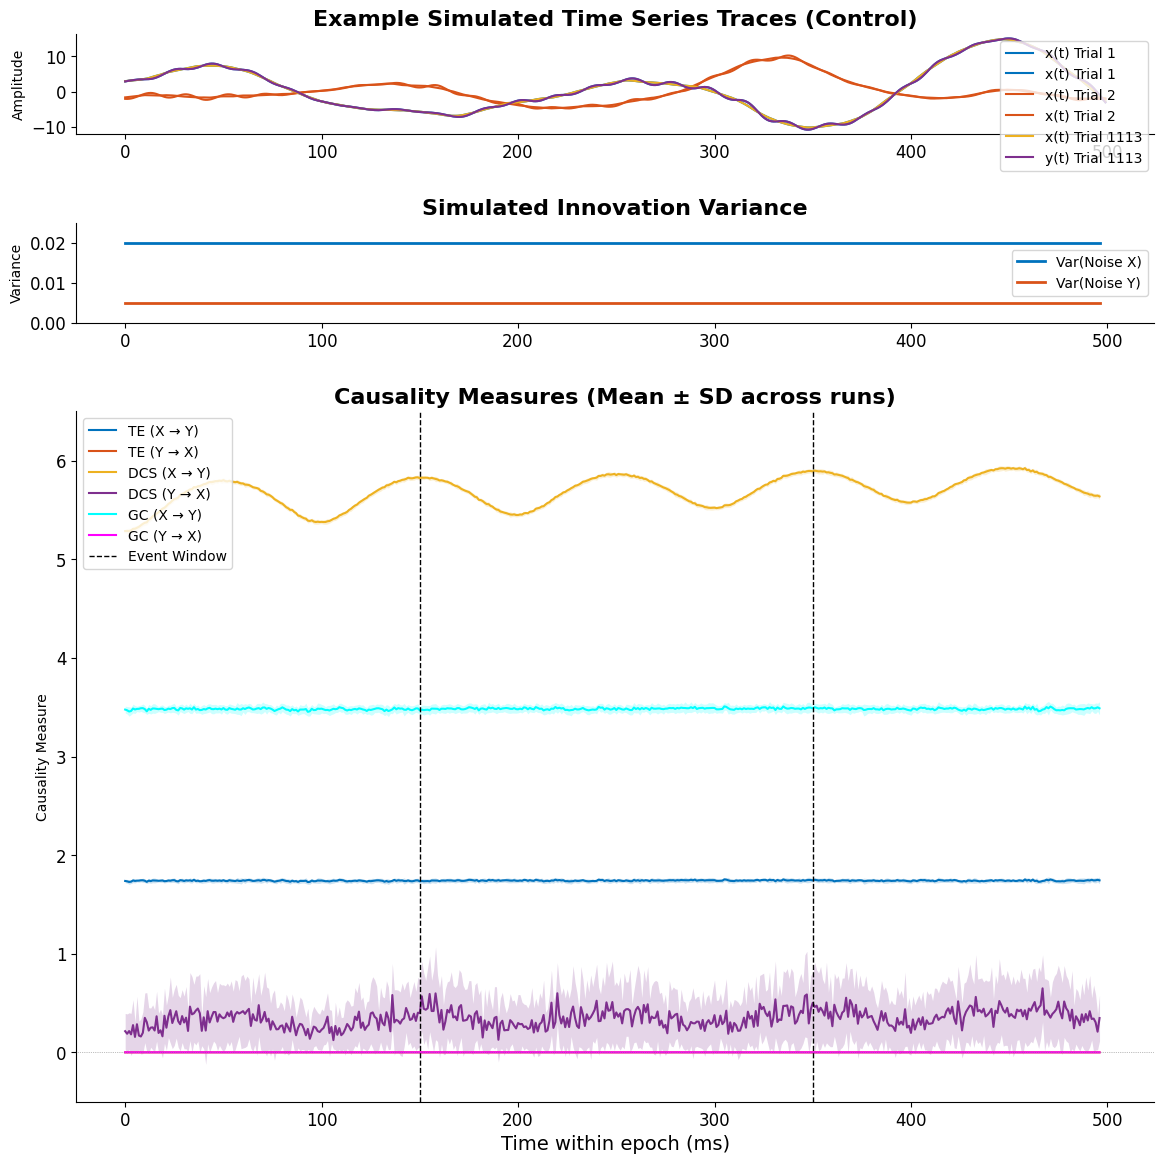

In [5]:
fig = plt.figure(figsize=(12, 12)) # Adjusted size slightly
gs = GridSpec(4, 1, figure=fig, height_ratios=[1, 1, 3, 3]) # Adjusted layout: 4 rows, 1 column

# --- Subplot 1: Example Time Series ---
ax1 = fig.add_subplot(gs[0]) # First row
if 'X' in locals() and X.shape[2] > 1 : # Check if X exists and has trials
    num_trials_available = X.shape[2]
    # Plot 2 randomly selected trials directly
    rand_trials_idx = np.random.choice(num_trials_available, 2, replace=False)
    ax1.plot(X[:, :, rand_trials_idx[0]].T, color=colors[0], linewidth=1.5, label='x(t) Trial 1')
    ax1.plot(X[:, :, rand_trials_idx[1]].T, color=colors[1], linewidth=1.5, label='x(t) Trial 2')
    ax1.plot(X[0, :, rand_trials_idx[0]], color=colors[2], linewidth=1.5, label=f'x(t) Trial {rand_trials_idx[0]}')
    ax1.plot(X[1, :, rand_trials_idx[0]], color=colors[3], linewidth=1.5, label=f'y(t) Trial {rand_trials_idx[0]}')
    ax1.legend()
else:
    ax1.text(0.5, 0.5, "'X' data not available or insufficient trials", ha='center', va='center')

ax1.set_title('Example Simulated Time Series Traces (Control)', fontsize=16, fontweight="bold")
ax1.tick_params(labelsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Amplitude')

# --- Subplot 2: Innovations Variance ---
ax2 = fig.add_subplot(gs[1], sharex=ax1)
start_idx_ns = 500
end_idx_ns = start_idx_ns + len(time_vector)
if 'ns_x' in locals() and 'ns_y' in locals() and len(ns_x) >= end_idx_ns:
    ax2.plot(time_vector, ns_x[start_idx_ns:end_idx_ns], color=colors[0], linewidth=2, label='Var(Noise X)')
    ax2.plot(time_vector, ns_y[start_idx_ns:end_idx_ns], color=colors[1], linewidth=2, label='Var(Noise Y)')
    ax2.legend(fontsize=10)
else:
    ax2.text(0.5, 0.5, "'ns_x'/'ns_y' data not available", ha='center', va='center')

ax2.set_title('Simulated Innovation Variance', fontsize=16, fontweight="bold")
ax2.set_ylim([y_lo, y_up])
ax2.tick_params(labelsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Variance')


# --- Subplot 3 & 4: Causality Results (TE, DCS, GC) ---
ax_causality = fig.add_subplot(gs[2:4], sharex=ax2)
ax_causality.clear()

if ('TE_mean' in locals() and TE_mean.shape[0] == len(time_vector) and
    'CS_mean' in locals() and CS_mean.shape[0] == len(time_vector) and
    'GC_mean' in locals() and GC_mean.shape[0] == len(time_vector)):

    # Plot Transfer Entropy (X->Y and Y->X) using colors from Cell 2
    fill_std_known(TE_mean[:, 0], TE_std[:, 0], time_vector, ax=ax_causality, color=colors[0], label="TE (X → Y)")
    fill_std_known(TE_mean[:, 1], TE_std[:, 1], time_vector, ax=ax_causality, color=colors[1], label="TE (Y → X)")

    # Plot Dynamic Causal Strength (X->Y and Y->X)
    fill_std_known(CS_mean[:, 0], CS_std[:, 0], time_vector, ax=ax_causality, color=colors[2], label="DCS (X → Y)")
    fill_std_known(CS_mean[:, 1], CS_std[:, 1], time_vector, ax=ax_causality, color=colors[3], label="DCS (Y → X)")

    # Plot Granger Causality (X->Y and Y->X)
    fill_std_known(GC_mean[:, 0], GC_std[:, 0], time_vector, ax=ax_causality, color='cyan', label="GC (X → Y)")
    fill_std_known(GC_mean[:, 1], GC_std[:, 1], time_vector, ax=ax_causality, color='magenta', label="GC (Y → X)")

    ax_causality.legend(fontsize=10, loc='upper left')
    ax_causality.set_ylim([-0.5, 6.5])
    ax_causality.axhline(0, color='gray', linestyle=':', linewidth=0.5) # Add line at y=0

    event_start_time = 150
    event_end_time = 350
    ax_causality.axvline(event_start_time, linestyle='--', color='k', linewidth=1, label='Event Window')
    ax_causality.axvline(event_end_time, linestyle='--', color='k', linewidth=1)
    handles, labels = ax_causality.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax_causality.legend(by_label.values(), by_label.keys(), fontsize=10, loc='upper left')

else:
    ax_causality.text(0.5, 0.5, "Causality results not available or shape mismatch", ha='center', va='center')

ax_causality.set_title('Causality Measures (Mean ± SD across runs)', fontsize=16, fontweight="bold")
ax_causality.tick_params(labelsize=12)
ax_causality.set_xlabel('Time within epoch (ms)', fontsize=14) # Clarify unit
ax_causality.set_ylabel('Causality Measure')
ax_causality.grid(False)
ax_causality.spines['top'].set_visible(False)
ax_causality.spines['right'].set_visible(False)

plt.tight_layout(pad=2.0) # Add padding

figure_filename = "figures/figure4a_replication_shao"
try:
    fig.savefig(f"{figure_filename}.svg", format='svg', bbox_inches='tight', dpi=300)
    fig.savefig(f"{figure_filename}.eps", format='eps', bbox_inches='tight')
    print(f"Figure saved successfully to: {figure_filename}")
except Exception as e:
    print(f"Error saving figure: {e}")

## Synchronized Case Simulation and Analysis (Morlet Wavelet)

The following cells simulate data where non-stationarity is introduced via Morlet wavelet modulation of the innovation variance (using `generate_signals` with `apply_morlet=True`).

We then analyze the resulting causal interactions under these conditions using the `dcs` package.

In [6]:
# Initialize lists to store results
causal_strength_results = []
transfer_entropy_results = []
granger_causality_results = []

# Configuration
num_sim_runs = 20
fixed_model_order = 2
use_diag_cov = False

print(f"Starting {num_sim_runs} simulation runs with model order {fixed_model_order}...")
start_time = time.time()

# Initialize DCS calculator for Morlet case
dcs_calculator_morlet = DCSCalculator(
    model_order=fixed_model_order,
    time_mode='inhomo',
    use_diagonal_covariance=use_diag_cov
)

for i in range(num_sim_runs):
    print(f"Running simulation {i+1}/{num_sim_runs}... with Morlet")
    X, ns_x, ns_y = generate_signals(T, Ntrial, h, gamma1, gamma2, Omega1, Omega2, apply_morlet=True)

    try:
        # Use the new DCSCalculator class
        result = dcs_calculator_morlet.analyze(X)
        
        # Extract results from the result object
        cs = result.causal_strength
        te = result.transfer_entropy
        gc = result.granger_causality

        causal_strength_results.append(cs)
        transfer_entropy_results.append(te)
        granger_causality_results.append(gc)
    except Exception as e:
        print(f"Error during causality calculation in run {i+1}: {e}")
        expected_time_points = T - 1 - fixed_model_order # Calculate expected time points in output
        if expected_time_points > 0:
             causal_strength_results.append(np.full((expected_time_points, 2), np.nan))
             transfer_entropy_results.append(np.full((expected_time_points, 2), np.nan))
             granger_causality_results.append(np.full((expected_time_points, 2), np.nan))

end_time = time.time()
print(f"\nFinished {num_sim_runs} runs in {end_time - start_time:.2f} seconds.")

# --- Convert results to NumPy arrays ---
# Shape: (num_runs, time_points, num_directions=2)
try:
    causal_strength_results = np.array(causal_strength_results)
    transfer_entropy_results = np.array(transfer_entropy_results)
    granger_causality_results = np.array(granger_causality_results)

    # --- Print shapes (as requested by user) ---
    print(f"\nResult array shapes (runs, time, directions):")
    print(f"  CS:  {causal_strength_results.shape}")
    print(f"  TE:  {transfer_entropy_results.shape}")
    print(f"  GC:  {granger_causality_results.shape}")

except ValueError as e:
    print(f"\nError converting results to NumPy arrays. Likely due to inconsistent shapes from run errors: {e}")
    print("Inspect the lists directly.")

Starting 20 simulation runs with model order 2...
Running simulation 1/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 2/20... with Morlet


/Users/sali/Documents/Projects/cmcLab/repos/rtdac/src/packages/dynamic-causal-strength/dcs/causality/dcs.py:296: RuntimeWarning: invalid value encountered in log
  result_arrays["granger_causality"][t, 1] = np.log(sigy_r / sigy)


Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 3/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 4/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 5/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 6/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 7/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 8/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 9/20... with Morlet
Starting DCSCalculator analysis on

/Users/sali/Documents/Projects/cmcLab/repos/rtdac/src/packages/dynamic-causal-strength/dcs/causality/dcs.py:296: RuntimeWarning: divide by zero encountered in log
  result_arrays["granger_causality"][t, 1] = np.log(sigy_r / sigy)


Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 11/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 12/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 13/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 14/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 15/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 16/20... with Morlet
Starting DCSCalculator analysis on data with shape (2, 500, 2000)
Completed DCSCalculator analysis
Running simulation 17/20... with Morlet
Starting DCSCalculator anal

In [7]:
se = np.zeros(Ntrial)
max_n = np.zeros(Ntrial)
print("Calculating trial statistics for the representative run...")
for n in range(Ntrial):
    temp = X[:, :, n]
    se[n] = np.sum((temp[0, :] - temp[1, :])**2)
    max_n[n] = np.max(temp)

idx_good_amplitude = max_n < 15 # Example: Trials without extreme values
idx_high_error = se > np.mean(se) # Example: Trials with high difference between signals
idx_combined = np.logical_and(idx_good_amplitude, idx_high_error)
indices_good_amplitude = np.where(idx_good_amplitude)[0]
print(f"Found {len(indices_good_amplitude)} trials with max amplitude < 15 in the representative run.")

# --- Average Causality Results Across Simulation Runs ---
print("Averaging causality results across runs...")
# Use nanmean for robustness against potential NaNs from run errors
TE_mean = np.nanmean(transfer_entropy_results, axis=0)  # Shape: (time, 2)
CS_mean = np.nanmean(causal_strength_results, axis=0)   # Shape: (time, 2)
GC_mean = np.nanmean(granger_causality_results, axis=0) # Shape: (time, 2)

TE_std = np.nanstd(transfer_entropy_results, axis=0)    # Shape: (time, 2)
CS_std = np.nanstd(causal_strength_results, axis=0)     # Shape: (time, 2)
GC_std = np.nanstd(granger_causality_results, axis=0)  # Shape: (time, 2)

print("Mean and Std Dev calculated.")
print(f"  Mean TE shape: {TE_mean.shape}")

print(f"  Mean CS shape: {CS_mean.shape}")
print(f"  Mean GC shape: {GC_mean.shape}")

# --- Define Time Vector for Plotting ---
num_time_points = TE_mean.shape[0]
time_vector = np.arange(num_time_points)
print(f"Created time vector with {len(time_vector)} points.")

Calculating trial statistics for the representative run...
Found 620 trials with max amplitude < 15 in the representative run.
Averaging causality results across runs...
Mean and Std Dev calculated.
  Mean TE shape: (497, 2)
  Mean CS shape: (497, 2)
  Mean GC shape: (497, 2)
Created time vector with 497 points.


/Users/sali/Documents/Projects/cmcLab/repos/rtdac/rtdac_venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


Figure saved successfully to: figures/figure4b_replication_shao


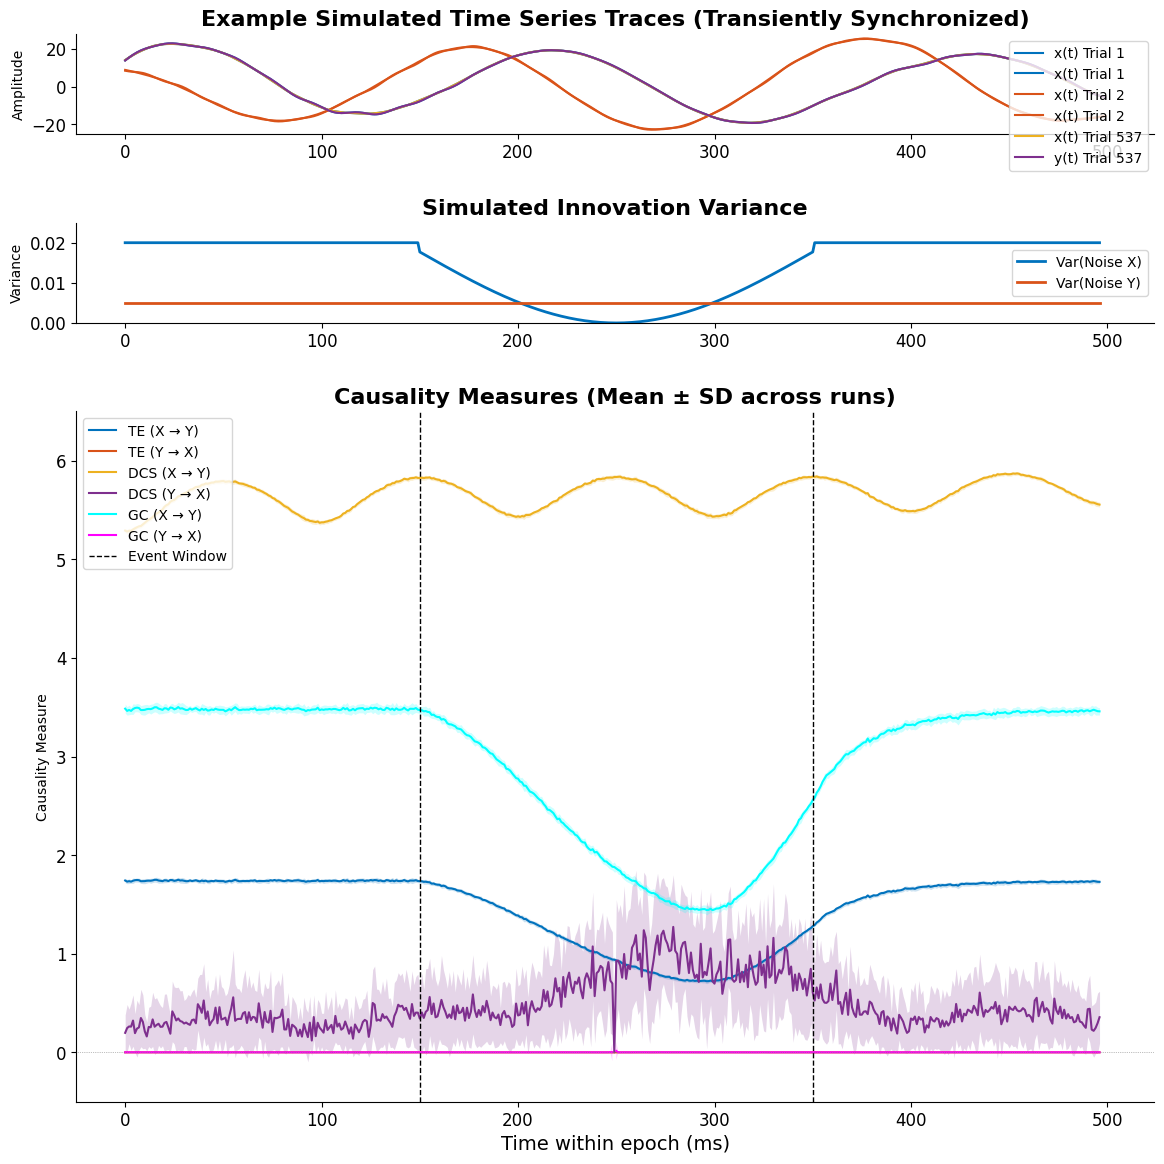

In [8]:
fig = plt.figure(figsize=(12, 12)) # Adjusted size slightly
gs = GridSpec(4, 1, figure=fig, height_ratios=[1, 1, 3, 3]) # Adjusted layout: 4 rows, 1 column

# --- Subplot 1: Example Time Series ---
ax1 = fig.add_subplot(gs[0]) # First row
if 'X' in locals() and X.shape[2] > 1 : # Check if X exists and has trials
    num_trials_available = X.shape[2]
    # Plot 2 randomly selected trials directly
    rand_trials_idx = np.random.choice(num_trials_available, 2, replace=False)
    ax1.plot(X[:, :, rand_trials_idx[0]].T, color=colors[0], linewidth=1.5, label='x(t) Trial 1')
    ax1.plot(X[:, :, rand_trials_idx[1]].T, color=colors[1], linewidth=1.5, label='x(t) Trial 2')
    ax1.plot(X[0, :, rand_trials_idx[0]], color=colors[2], linewidth=1.5, label=f'x(t) Trial {rand_trials_idx[0]}')
    ax1.plot(X[1, :, rand_trials_idx[0]], color=colors[3], linewidth=1.5, label=f'y(t) Trial {rand_trials_idx[0]}')
    ax1.legend()
else:
    ax1.text(0.5, 0.5, "'X' data not available or insufficient trials", ha='center', va='center')

ax1.set_title('Example Simulated Time Series Traces (Transiently Synchronized)', fontsize=16, fontweight="bold")
ax1.tick_params(labelsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Amplitude')

# --- Subplot 2: Innovations Variance ---
ax2 = fig.add_subplot(gs[1], sharex=ax1)
start_idx_ns = 500
end_idx_ns = start_idx_ns + len(time_vector)
if 'ns_x' in locals() and 'ns_y' in locals() and len(ns_x) >= end_idx_ns:
    ax2.plot(time_vector, ns_x[start_idx_ns:end_idx_ns], color=colors[0], linewidth=2, label='Var(Noise X)')
    ax2.plot(time_vector, ns_y[start_idx_ns:end_idx_ns], color=colors[1], linewidth=2, label='Var(Noise Y)')
    ax2.legend(fontsize=10)
else:
    ax2.text(0.5, 0.5, "'ns_x'/'ns_y' data not available", ha='center', va='center')

ax2.set_title('Simulated Innovation Variance', fontsize=16, fontweight="bold")
ax2.set_ylim([y_lo, y_up])
ax2.tick_params(labelsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Variance')


# --- Subplot 3 & 4: Causality Results (TE, DCS, GC) ---
ax_causality = fig.add_subplot(gs[2:4], sharex=ax2)
ax_causality.clear()

if ('TE_mean' in locals() and TE_mean.shape[0] == len(time_vector) and
    'CS_mean' in locals() and CS_mean.shape[0] == len(time_vector) and
    'GC_mean' in locals() and GC_mean.shape[0] == len(time_vector)):

    # Plot Transfer Entropy (X->Y and Y->X) using colors from Cell 2
    fill_std_known(TE_mean[:, 0], TE_std[:, 0], time_vector, ax=ax_causality, color=colors[0], label="TE (X → Y)")
    fill_std_known(TE_mean[:, 1], TE_std[:, 1], time_vector, ax=ax_causality, color=colors[1], label="TE (Y → X)")

    # Plot Dynamic Causal Strength (X->Y and Y->X)
    fill_std_known(CS_mean[:, 0], CS_std[:, 0], time_vector, ax=ax_causality, color=colors[2], label="DCS (X → Y)")
    fill_std_known(CS_mean[:, 1], CS_std[:, 1], time_vector, ax=ax_causality, color=colors[3], label="DCS (Y → X)")

    # Plot Granger Causality (X->Y and Y->X)
    fill_std_known(GC_mean[:, 0], GC_std[:, 0], time_vector, ax=ax_causality, color='cyan', label="GC (X → Y)")
    fill_std_known(GC_mean[:, 1], GC_std[:, 1], time_vector, ax=ax_causality, color='magenta', label="GC (Y → X)")

    ax_causality.legend(fontsize=10, loc='upper left')
    ax_causality.set_ylim([-0.5, 6.5])
    ax_causality.axhline(0, color='gray', linestyle=':', linewidth=0.5) # Add line at y=0

    event_start_time = 150
    event_end_time = 350
    ax_causality.axvline(event_start_time, linestyle='--', color='k', linewidth=1, label='Event Window')
    ax_causality.axvline(event_end_time, linestyle='--', color='k', linewidth=1)
    handles, labels = ax_causality.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax_causality.legend(by_label.values(), by_label.keys(), fontsize=10, loc='upper left')

else:
    ax_causality.text(0.5, 0.5, "Causality results not available or shape mismatch", ha='center', va='center')

ax_causality.set_title('Causality Measures (Mean ± SD across runs)', fontsize=16, fontweight="bold")
ax_causality.tick_params(labelsize=12)
ax_causality.set_xlabel('Time within epoch (ms)', fontsize=14) # Clarify unit
ax_causality.set_ylabel('Causality Measure')
ax_causality.grid(False)
ax_causality.spines['top'].set_visible(False)
ax_causality.spines['right'].set_visible(False)

# --- Final Adjustments ---
plt.tight_layout(pad=2.0) # Add padding

# --- ADDED LINE TO SAVE FIGURE ---
figure_filename = "figures/figure4b_replication_shao"
try:
    fig.savefig(f"{figure_filename}.svg", format='svg', bbox_inches='tight', dpi=300)
    fig.savefig(f"{figure_filename}.eps", format='eps', bbox_inches='tight')
    print(f"Figure saved successfully to: {figure_filename}")
except Exception as e:
    print(f"Error saving figure: {e}")